<a href="https://colab.research.google.com/github/immabridget/Timeseries-models/blob/main/Tensorflow_Structural_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and data


In [ ]:
#import libraries
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data.csv to Data (1).csv


In [ ]:
#get the data
df=pd.read_csv("Data.csv",index_col="Date",parse_dates=True)
df.head()

,Amount
Date,
2020-01-02,0.002
2020-01-03,0.003
2020-01-04,35000.003
2020-01-05,35000.004
2020-01-06,35000.005


In [ ]:
df = df.asfreq('D')
df.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', name='Date', length=139, freq='D')

#Data Transformation

In [ ]:
df.head()

,Amount
Date,
2020-01-02,0.002
2020-01-03,0.003
2020-01-04,35000.003
2020-01-05,35000.004
2020-01-06,35000.005


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2020-01-02 to 2020-05-19
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  139 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


#Training and Test Set

In [ ]:
#Training and test set
test_days = 30
training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:, :]
test_set.tail(1)

,Amount
Date,
2020-05-19,959000.012


#Regressors

In [ ]:
#get a library
import tensorflow_probability as tfp

In [ ]:
#isolating dependent variable
y = training_set['Amount'].astype(np.float64)
y[:5]

Date
2020-01-02        0.002
2020-01-03        0.003
2020-01-04    35000.003
2020-01-05    35000.004
2020-01-06    35000.005
Freq: D, Name: Amount, dtype: float64

#Seasonality

In [ ]:
#Weekday seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7,
                                  num_steps_per_season = 1,
                                  observed_time_series = y,
                                  name = "weekday_effect")

In [ ]:
#number of days per month
num_days_per_month = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])#2020
     

In [ ]:
#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12,
                                  num_steps_per_season = num_days_per_month,
                                  observed_time_series = y,
                                  name = "monthly_effect")

#Autoregressive and Trend components

In [ ]:
#trend 
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")

In [ ]:
#Autoregressive
autoregressive = tfp.sts.Autoregressive(order = 1,
                                        observed_time_series = y,
                                        name = "autoregressive")

#Tensorflow Structural Time series

In [ ]:
#forecasting model
model = tfp.sts.Sum([
                     weekday_effect,
                     #monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

In [ ]:
#fit with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [ ]:
#forecast
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(test_set))

In [ ]:
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = test_set.index
predictions_tfp[:2]

Date
2020-04-20    134509.468224
2020-04-21    151514.727036
Freq: D, Name: TFP, dtype: float64

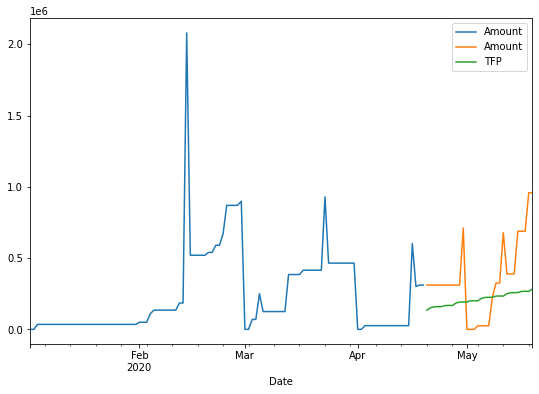

In [ ]:
#visualization
training_set['Amount'].plot(figsize = (9,6), legend = True)
test_set['Amount'].plot(legend = True)
predictions_tfp.plot(legend = True)

#Model assessment

In [ ]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['Amount'], predictions_tfp),0))
print(round(np.sqrt(mean_squared_error(test_set['Amount'], predictions_tfp)), 0))

234028.0
288586.0


#export forecasts

In [ ]:
predictions_tfp.to_csv('predictions_tfp.csv', index = True)